# Echo State Network against Time Series

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from qbraid_algorithms import EchoStateNetwork, EchoStateReservoir
from qbraid_algorithms.reservoir_computing.datasets import create_time_series_data

Format Time Series data to work with the ESN

In [2]:
# Parameters
cycles = 10
n_steps = 10

# Time series creation
trainset = create_time_series_data(1000, cycles, n_steps)
trainloader = DataLoader(trainset, shuffle=True)
testset = create_time_series_data(400, cycles, n_steps)
testloader = DataLoader(testset, shuffle=True)

Initialize echo state network

In [3]:
input_size = 10
output_size = 1
hyperparams = {
    "hidden_size": 2500,
    "sparsity": 0.9,
    "spectral_radius": 0.99,
    "a": 0.6,
    "leak": 1.0,
}

reservoir = EchoStateReservoir(input_size, **hyperparams)
esn = EchoStateNetwork(reservoir, output_size).float()

Initialize optimizer using ESN parameters, and define loss criterion

In [4]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(esn.parameters(), lr=0.00001)

Train the network

In [5]:
nsamples = 1000
nepochs = 200
loss_values = []

start = time.time()
for epoch in range(nepochs):
    total_loss = 0.0
    for i, dat in enumerate(trainset, 0):
        seq = dat[0]
        target = dat[1]

        optimizer.zero_grad()

        output = esn(seq)[0]
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / nsamples
    loss_values.append(average_loss)
    print(f"epoch {epoch}, loss: {average_loss:.3f}")

    if average_loss < 1e-3:
        break

end = time.time()

seconds = int(end - start)
minutes = seconds // 60
print(f"Training duration: {minutes} min {seconds % 60} sec")

/Users/ryanhill/anaconda3/envs/algorithms/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss: 0.061
epoch 1, loss: 0.003
epoch 2, loss: 0.001
Training duration: 0 min 3 sec


Plot the loss

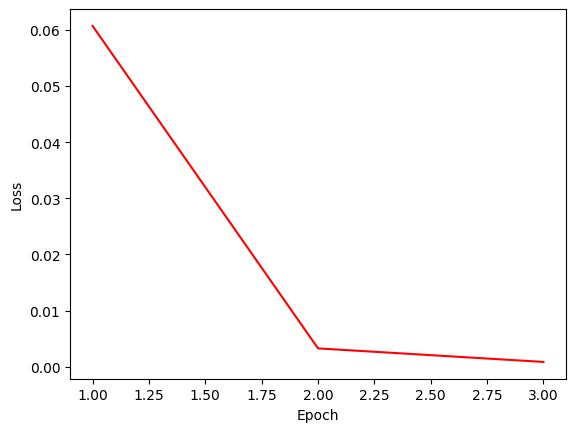

In [6]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(range(1, len(loss_values) + 1), loss_values, color="red")
plt.show()

Plot against desired data, giving R^2 as well

R^2:  -1.1314130091731576


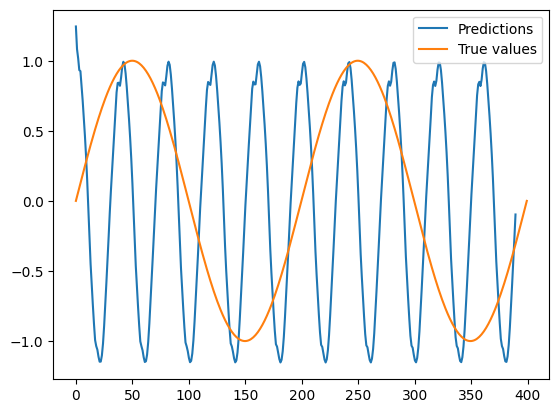

In [7]:
esn.eval()
predictions = []

with torch.no_grad():
    for inputs, targets in testloader.dataset:
        output = esn(inputs)[0]
        predictions.append(output)

t_test = np.linspace(2 * np.pi * 10, 2 * np.pi * 12, 400)
plt.plot(torch.cat(predictions).numpy(), label="Predictions")
plt.plot([np.sin(y) for y in t_test], label="True values")
plt.legend()

y_true = np.sin(t_test)
y_pred = torch.cat(predictions).numpy().flatten()
y_true_mean = np.mean(y_true)
ss_tot = np.sum((y_true - y_true_mean) ** 2)
ss_res = np.sum((y_true[:390] - y_pred) ** 2)
r2 = 1 - ss_res / ss_tot
print("R^2: ", r2)